In [1]:
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import numpy as np
import matplotlib.colors as colors
from scipy.interpolate import make_interp_spline
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import convolve
import matplotlib.patches as patches
import netCDF4

In [2]:
'''
Add a circular filter to get the 250km average of each grid point. 

'''
def circular_kernel(radius):
    # x is a horizontal 1D array with values that go from -9 to 9
    # y is a vertical 1D array with values that go from 9 to -9
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    # x**2 + y **2 calculates the square distance from (0,0) for each 
    # point in the grid 
    # The mask is a boolean array of dimension (x,y) 
    # to indicate the pixels that are within the 250km (9 pixel) radius
    mask = x**2 + y**2 <= radius**2
    # The kernel is the same dimension as the mask
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    # Assign 1 if mask = true and 0 il mask = false
    kernel[~mask] = 0
    return kernel

def normalize_kernel(kernel):
    # change 1 values in kernel for the normalized value.
    # This will allow us to calculate the average with convolve
    return kernel / np.sum(kernel)

def circular_uniform_filter(array, radius):
    kernel = circular_kernel(radius)
    normalized_kernel = normalize_kernel(kernel)
    # Convolve takes the storm_interp as a parameter.
    # Convolve will be centered over a given grid point in storm_interp. 
    # It will then get multiply the kernel values with all the corresponding
    # neighbors (the grid points in storm_interp that are within the kernel boundaries)
    # It will then add all the products together and assign the result to the
    # grid point on which the kernel is centered. 
    return convolve(array, normalized_kernel)

In [12]:
def add_features() : 
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none', zorder=15)
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.9')
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='None',
                                            facecolor=[(0.59375 , 0.71484375, 0.8828125)])
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black',
                                            facecolor='None',lw=1.2)
    #(0.59375 , 0.71484375, 0.8828125)
    ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='black', facecolor='none', zorder=10))
    ax.add_feature(land_50m,edgecolor='black');
    ax.add_feature(lakes_50m_edge, zorder=10);
    ax.add_feature(cfeature.BORDERS, zorder=10,edgecolor='black');
    ax.coastlines('50m', zorder=15, color='black',lw=1.2)

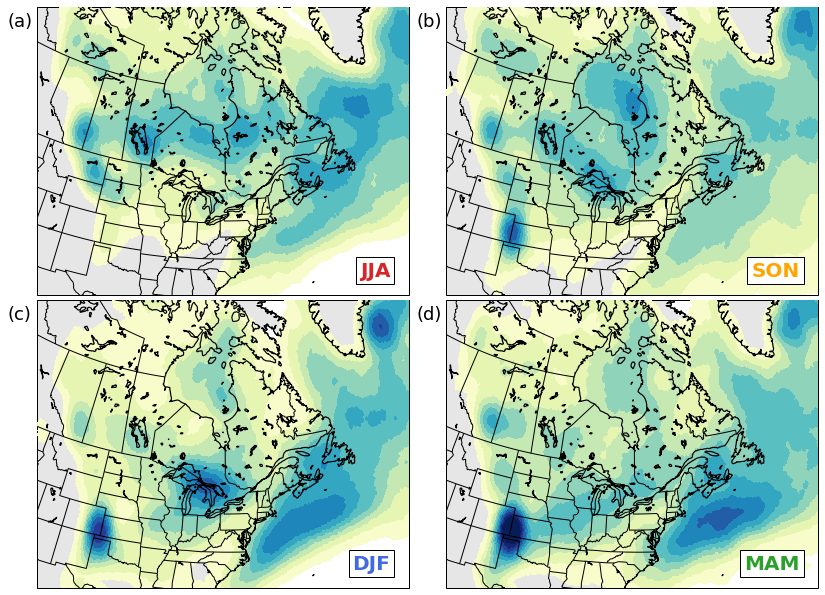

In [76]:
# Read NAEC that contains the season column
df = pd.read_csv('/pampa/cloutier/track_density/NAEC/NAEC_track_den_each_gp.csv')

seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['C3', 'orange', 'royalblue', 'C2']
fig_index = ['(a)', '(b)', '(c)', '(d)']

fig = plt.figure(figsize=(14,12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])

i = 1

# Distance entre 2 points de grille = 0.25° 
# 111.3km/° -> 27.825 km entre deux points de grille
# Dans un rayon de 250km, on a 8.98 (9) points de grille.
radius = 9

for szn, col, idx in zip(seasons, colors, fig_index) :
    data = df.loc[df.season==szn]
    lat = data['latitude']
    lon = data['longitude']
    storms = data['storm_count']

    # Define the grid for interpolation
    grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

    # Perform nearest neighbor interpolation
    storms_interp = griddata((lon, lat), storms, (grid_x, grid_y),method='nearest')
    
    # create sub figures
    ax = fig.add_subplot(2, 2, i, projection=proj)
    i += 1
    extent=(-110, -50, 27.5, 67.3)
    add_features()
    ax.set_extent(extent)

    # Add circular filter
    storms_circ = circular_uniform_filter(storms_interp, radius)

    # Plot the filled contours
    contour = ax.contourf(grid_x, grid_y, storms_circ, transform=ccrs.PlateCarree(), 
                          zorder=9, cmap=plt.cm.get_cmap('YlGnBu'), levels=np.arange(1,12,1), extend='max')
    
    ax.spines['geo'].set_linewidth(1)
    
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, zorder=16, fontweight ='bold', color=col)
    
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)


# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace = 0.1)

plt.show()

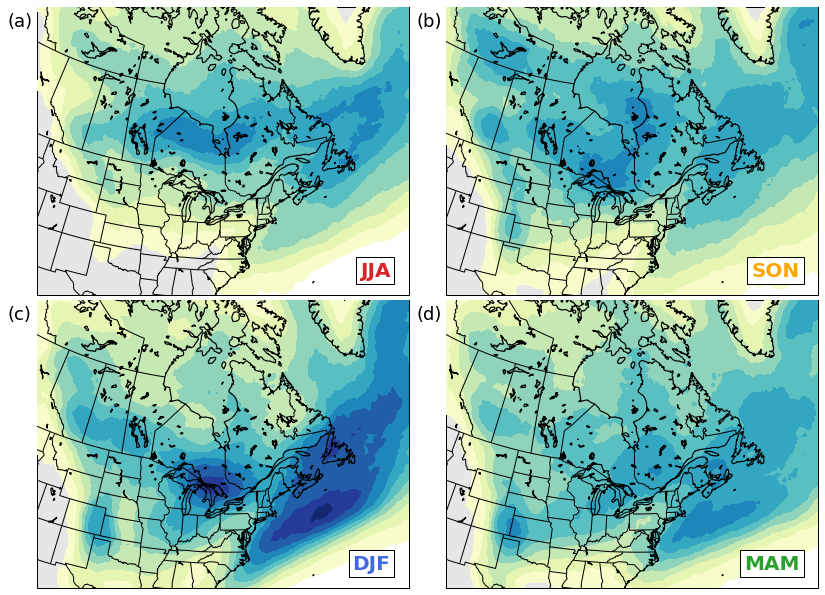

In [78]:
# Read NAEC that contains the season column
Track=netCDF4.Dataset('/pampa/cloutier/track_density/NAEC/Track_density_1979_2020_all_seasons_250km.nc','r')

seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['C3', 'orange', 'royalblue', 'C2']
fig_index = ['(a)', '(b)', '(c)', '(d)']

fig = plt.figure(figsize=(14,12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])

i = 1

# Distance entre 2 points de grille = 0.25° 
# 111.3km/° -> 27.825 km entre deux points de grille
# Dans un rayon de 250km, on a 8.98 (9) points de grille.
radius = 9

for szn, col, idx in zip(seasons, colors, fig_index) :
    season = szn
    lat0 = Track.variables['latitude'][:]
    lon0 = Track.variables['longitude'][:]
    den = Track.variables['trackDen_'+season+''][:,:]*1./42.
    lon, lat = np.meshgrid(lon0, lat0)
    
    # create sub figures
    ax = fig.add_subplot(2, 2, i, projection=proj)
    i += 1
    extent=(-110, -50, 27.5, 67.3)
    add_features()
    ax.set_extent(extent)

    # Add circular filter
    storms_circ = circular_uniform_filter(storms_interp, radius)

    # Plot the filled contours
    contour = ax.contourf(lon, lat, den, transform=ccrs.PlateCarree(), 
                          zorder=9, cmap=plt.cm.get_cmap('YlGnBu'), levels=np.arange(1,12,1), extend='max')
    
    ax.spines['geo'].set_linewidth(1)
    
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, zorder=16, fontweight ='bold', color=col)
    
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)


# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace = 0.1)

plt.show()

110356 127595 120048 118922


476921

476921
